In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [2]:
sales = pd.read_csv('us_retail_sales.csv')
sales.head()

In [3]:
# transpose the dataframe to reorient the data 
salest = sales.transpose()
salest.head()

In [4]:
# reassign the 'YEAR' feature as column names 
salest.columns = sales['YEAR']
salest.drop(['YEAR'], axis=0, inplace=True)

In [7]:
# create a new feature for month
salest['month'] = salest.index

In [44]:
# melt the data for a tsa workable format 
sm = pd.melt(salest, id_vars='month')
sm

In [46]:
# create a datetime feature 
sm['date'] = pd.to_datetime([f'{y}-{m}-01' for y, m in zip(sm.YEAR, sm.month)])

In [61]:
# reset the df index to the datetime feature 
sm = sm.set_index('date')

In [47]:
# drop all NaN values 
sm.dropna(inplace= True)

## Plot Sales Data

Text(0.5, 1.0, 'Sales over Time (1992-2021)')

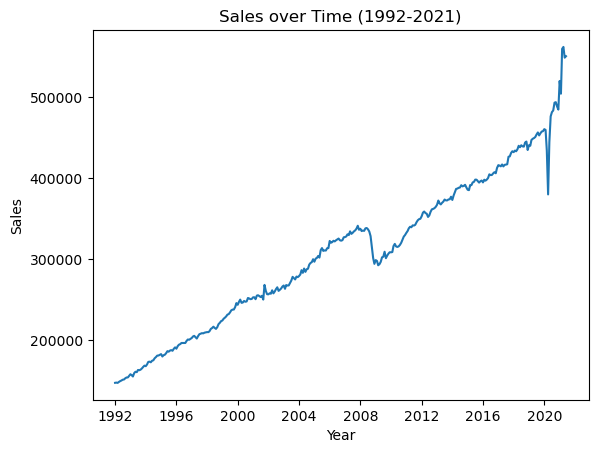

In [160]:
# plot sales by month over time
plt.plot(sm.index, sm['value'])
plt.ylabel('Sales')
plt.xlabel('Year')
plt.title('Sales over Time (1992-2021)')

In general, there has been an upward trend in sales over the years from 1992 to 2020. There are two noticable drops: one in 2008, likely correlating with the financial crisis and one in 2020, likely correlated with the pandemic. Following the second drop, there is a large upswing in sales. Overall, the sales data displays a fairly linear relationship over time. 

Text(0.5, 1.0, 'Boxplot of sales grouped by year')

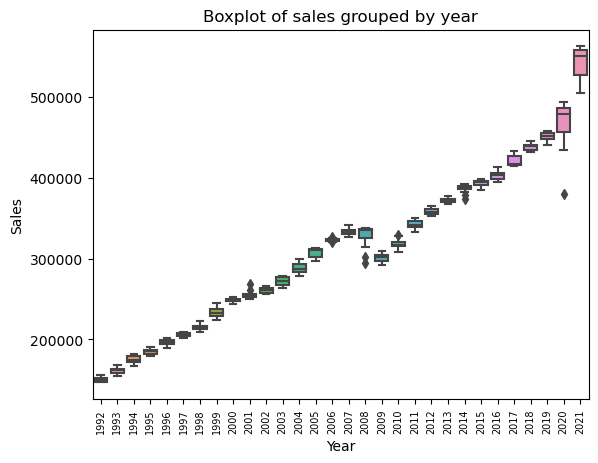

In [163]:
# plot sales as boxplots grouped by year to view spread 
sns.boxplot(data=sm, x='YEAR', y='value')
plt.xticks(rotation = 90, size=7)
plt.ylabel('Sales')
plt.xlabel('Year')
plt.title('Boxplot of sales grouped by year')

There is a range in the amount of spread in sales from year to year. There is a particularily high spread in more recent years including 2020 and 2021.

Text(0.5, 1.0, 'Boxplot of sales grouped by month')

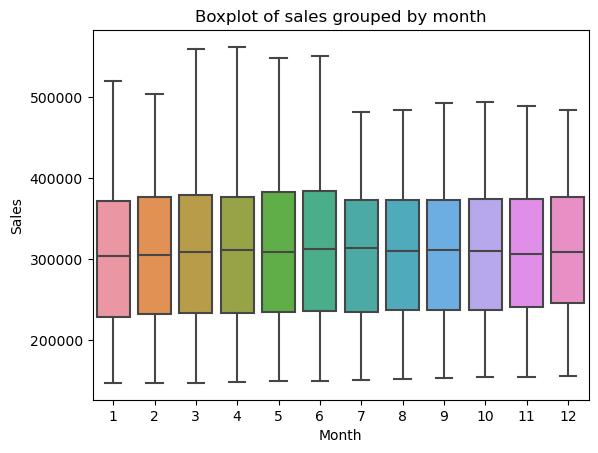

In [162]:
# plot sales as boxplots grouped by month to view spread 
sns.boxplot(data=sm, x='month', y='value')
plt.ylabel('Sales')
plt.xlabel('Month')
plt.title('Boxplot of sales grouped by month')

There is more spread in some months (such as March and April) than other months (such as July and August), but there does not appear to be any seasonal trend in sales. 

## Train / Test Split

In [62]:
train = sm.loc[sm.index < '2020-05-01']
test = sm.loc[sm.index >= '2020-05-01']

## Create an Exponential Smoothing Model 

Text(0.5, 1.0, 'Exponential Smoothing Model 1')

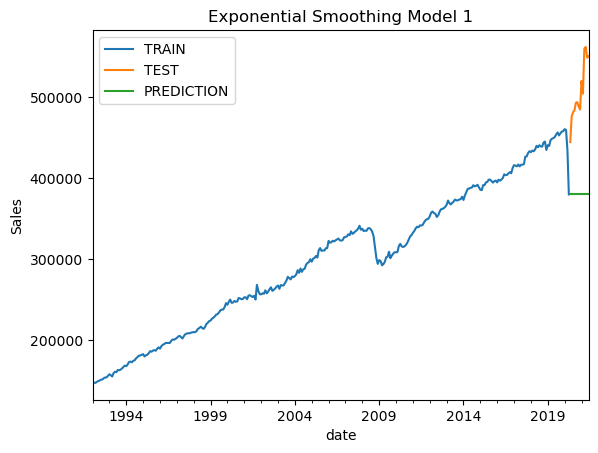

In [166]:
model = ExponentialSmoothing(train['value']).fit()
predict = model.forecast(14)
train['value'].plot(legend=True, label='TRAIN')
test['value'].plot(legend=True, label='TEST')
predict.plot(legend=True, label='PREDICTION')
plt.ylabel('Sales')
plt.title('Exponential Smoothing Model 1')

## Calculate the RMSE of the model

In [138]:
print('RMSE of Model:\n', sqrt(mean_squared_error(test['value'], predict)))

RMSE of Model:
 131207.60743730192


## Rework the model to lower the RMSE

In [86]:
# Perform the train/test split further back on the time series 
train1 = sm.loc[sm.index < '2018-05-01']
test1 = sm.loc[sm.index >= '2018-05-01']

Text(0.5, 1.0, 'Exponential Smoothing Model 2')

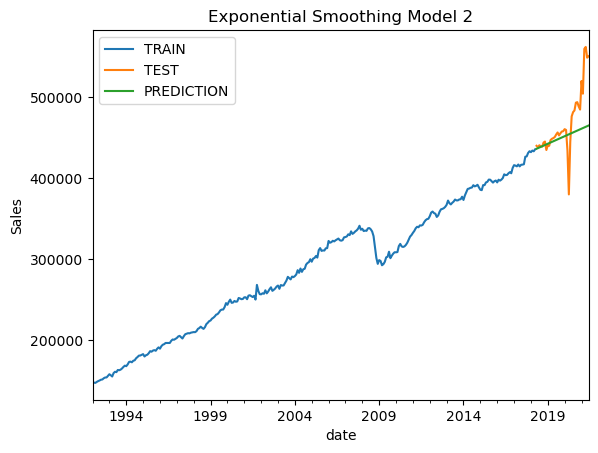

In [165]:
# Create a second model with the new train/test sets
model1 = ExponentialSmoothing(train1['value'], trend='additive').fit()
predict1 = model1.forecast(38)
train1['value'].plot(legend=True, label='TRAIN')
test1['value'].plot(legend=True, label='TEST')
predict1.plot(legend=True, label='PREDICTION')
plt.ylabel('Sales')
plt.title('Exponential Smoothing Model 2')

In [118]:
print('RMSE of Model 2:\n', sqrt(mean_squared_error(test1['value'], predicitions1)))

RMSE of Model 2:
 36728.46826622972


Text(0.5, 1.0, 'Exponential Smoothing Model 3')

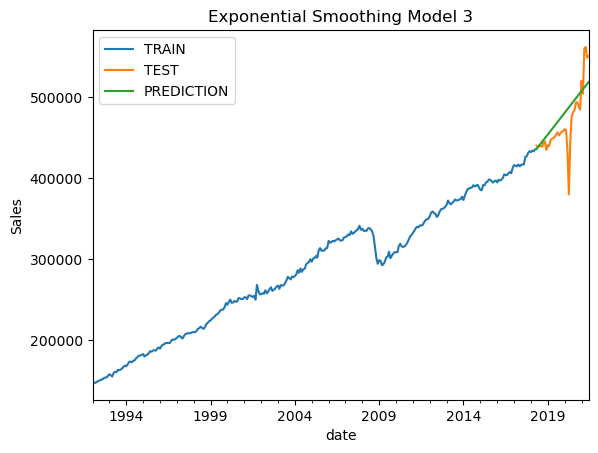

In [164]:
# create a new model with a modified alpha 
model2 = ExponentialSmoothing(train1['value'], trend='additive').fit(smoothing_trend=2)
predict2 = model2.forecast(38)

train1['value'].plot(legend=True, label='TRAIN')
test1['value'].plot(legend=True, label='TEST')
predict2.plot(legend=True, label='PREDICTION')
plt.ylabel('Sales')
plt.title('Exponential Smoothing Model 3')

In [142]:
print('RMSE of Model 3:\n', sqrt(mean_squared_error(test1['value'], predicitions2)))

RMSE of Model 3:
 27416.921842225143


Model 3 most closely fits the data, as indicated by the small RMSE relative to the two other models. The dip in salse observed in 2020 interferred with the forecasting of the first model, and the steepness of the slope in sales from 2020-2021 was difficult to capture in model 2 without hyperparameter tuning. 